In [1]:
import pandas as pd
import numpy as np
import random
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import Ridge,Lasso
from sklearn.metrics import mean_squared_error,r2_score
from sklearn.model_selection import cross_val_score
#from pyproj import Proj,transform
import statsmodels.api as sm
import statsmodels.formula.api as smf
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import RobustScaler

!pip install bayesian-optimization

import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import roc_auc_score   # AUC 스코어 계산
from sklearn.metrics import accuracy_score,log_loss,f1_score
from sklearn.model_selection import KFold,StratifiedKFold   # K-fold CV    
from sklearn.metrics import classification_report
from bayes_opt import BayesianOptimization  # 베이지안 최적화 라이브러리  
from functools import partial               # 함수 변수 고정
import lightgbm as lgb                      # LightGBM 라이브러리
import warnings       
warnings.filterwarnings("ignore")
import numpy as np
from imblearn.over_sampling import SMOTE

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


# 한글 폰트 설정

In [2]:
import matplotlib as mpl
import matplotlib.pyplot as plt
 
%config InlineBackend.figure_format = 'retina'
 
!apt -qq -y install fonts-nanum
 
import matplotlib.font_manager as fm
fontpath = '/usr/share/fonts/truetype/nanum/NanumBarunGothic.ttf'
font = fm.FontProperties(fname=fontpath, size=9)
plt.rc('font', family='NanumBarunGothic') 
mpl.font_manager._rebuild()

fonts-nanum is already the newest version (20170925-1).
0 upgraded, 0 newly installed, 0 to remove and 25 not upgraded.


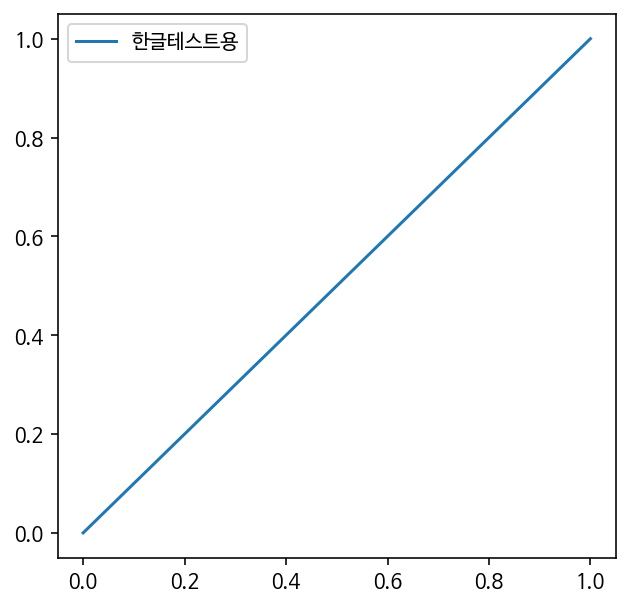

In [3]:
plt.figure(figsize=(5,5))
plt.plot([0,1], [0,1], label='한글테스트용')
plt.legend()
plt.show()

# Euclid: 150

In [0]:
data = pd.read_csv('/content/drive/My Drive/Colab Notebooks/data/공모전/동작구_공모전/sell_오만_250.csv')
data.drop('Unnamed: 0',axis=1,inplace=True)

In [5]:
data.head()

,x,y,소로,중로2류,소로1류,소로3류,중로3류,소로2류,중로1류,광로2류,old_place,child_place,crosswork,building,bus,bohang,accident
0,194809.973242,544707.468491,51,0,0,2,1,0,0,0,3.0,8.0,14.0,522.0,10.0,0.0,0.0
1,198016.558488,543244.282260,23,0,0,1,0,2,0,0,4.0,10.0,13.0,330.0,10.0,0.0,0.0
2,195021.095277,544130.126764,22,0,0,2,0,2,0,0,1.0,6.0,11.0,557.0,26.0,0.0,2.0
3,194439.006816,545401.473426,84,0,0,0,0,0,0,0,2.0,3.0,2.0,933.0,0.0,0.0,0.0
4,193832.323949,544119.840675,56,0,0,5,0,8,0,0,1.0,5.0,6.0,663.0,12.0,1.0,0.0


In [6]:
data.shape

(23801, 17)

## Linear Regression

회귀분석을 위해 0이 많은 행을 random으로 삭제를 해주자.

In [0]:
random_0=data[data['accident']==0].sample(10000)

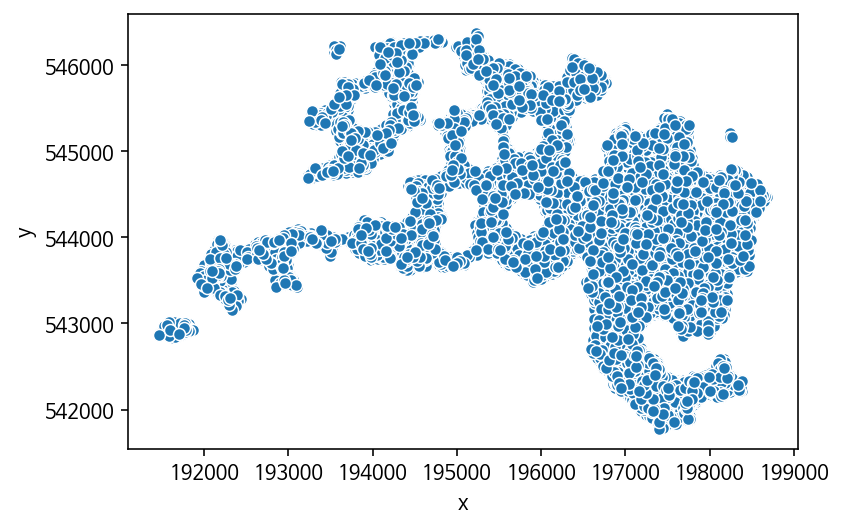

In [8]:
sns.scatterplot(random_0['x'],random_0['y'])

In [0]:
not_0=data[data['accident']>0]

In [0]:
data=pd.concat([random_0,not_0])
data.sort_index(ascending=True,inplace=True)

- Scailing

In [11]:
data.columns[2:-1]

Index(['소로', '중로2류', '소로1류', '소로3류', '중로3류', '소로2류', '중로1류', '광로2류',
       'old_place', 'child_place', 'crosswork', 'building', 'bus', 'bohang'],
      dtype='object')

In [0]:
robust_scaler = RobustScaler()
scaled_X=robust_scaler.fit_transform(data[data.columns[2:-1]])
scaled_X= pd.DataFrame(scaled_X,columns=data.columns[2:-1])
scaled_X

scaled_y = np.log1p(data['accident'])

(array([10000.,     0.,  4416.,     0.,  2675.,  1040.,   901.,   498.,
          308.,   127.]),
 array([0.        , 0.26390573, 0.52781147, 0.7917172 , 1.05562293,
        1.31952866, 1.5834344 , 1.84734013, 2.11124586, 2.3751516 ,
        2.63905733]),
 <a list of 10 Patch objects>)

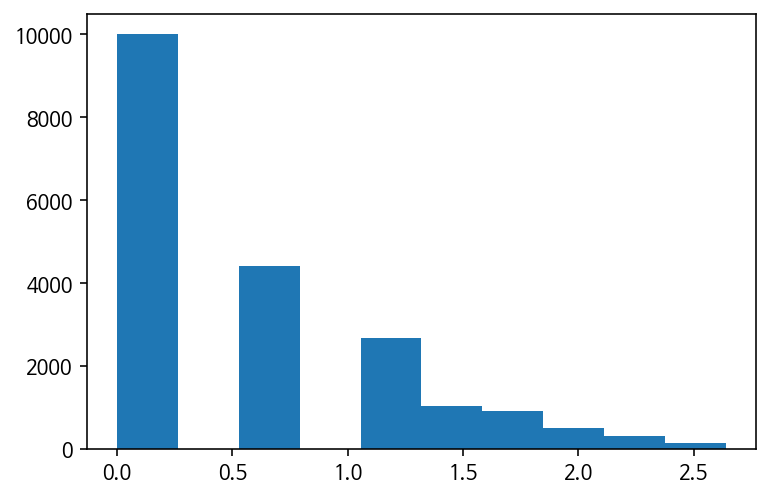

In [13]:
plt.hist(scaled_y)

흠 생각보다 원하는 정규분포 형태로 잘 안바뀌긴한다.

Lasso

In [14]:
lasso_alphas=[0,0.01,0.03,0.05,0.07,0.1,0.5,1,3]

coeff_df = pd.DataFrame()
for idx, alpha in enumerate(lasso_alphas):
  lasso = Lasso(alpha).fit(scaled_X,scaled_y)
  pred = lasso.predict(scaled_X)
  coeff = pd.Series(data=lasso.coef_,index=scaled_X.columns)
  colname = 'alpha:'+str(alpha)
  coeff_df[colname] = coeff
  print('Train Variance score:',r2_score(scaled_y,pred))

Train Variance score: 0.3686103210983168
Train Variance score: 0.35745880549238407
Train Variance score: 0.33039472568866746
Train Variance score: 0.29606600662988614
Train Variance score: 0.2624205903106329
Train Variance score: 0.22705849396910516
Train Variance score: 0.0
Train Variance score: 0.0
Train Variance score: 0.0


In [15]:
coeff_df

,alpha:0,alpha:0.01,alpha:0.03,alpha:0.05,alpha:0.07,alpha:0.1,alpha:0.5,alpha:1,alpha:3
소로,0.215017,0.183448,0.103192,0.046318,0.000000,0.000000,0.0,0.0,0.0
중로2류,0.053680,0.000000,0.000000,0.000000,-0.000000,0.000000,0.0,0.0,0.0
소로1류,0.024415,0.016908,0.010827,0.008178,0.003225,0.000000,0.0,0.0,0.0
소로3류,-0.063617,-0.042814,-0.006585,-0.000000,-0.000000,-0.000000,0.0,0.0,0.0
중로3류,0.013469,0.000000,-0.000000,-0.000000,-0.000000,-0.000000,0.0,0.0,0.0
소로2류,0.060437,0.061976,0.063485,0.065090,0.065407,0.060431,0.0,0.0,0.0
중로1류,0.301882,0.064475,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.0
광로2류,-0.058840,-0.000000,-0.000000,-0.000000,-0.000000,-0.000000,-0.0,-0.0,-0.0
old_place,-0.106307,-0.102505,-0.065515,-0.017897,-0.000000,-0.000000,0.0,0.0,0.0
child_place,-0.081690,-0.023489,-0.000000,-0.000000,0.000000,0.000000,0.0,0.0,0.0


## tree model(이진분류)
-  XGboost

In [0]:
data = pd.read_csv('/content/drive/My Drive/Colab Notebooks/data/공모전/동작구_공모전/sell_오만_250.csv')
data.drop('Unnamed: 0',axis=1,inplace=True)

In [0]:
# 파생변수 제작
data['old/building'] = data['old_place']/data['building']
data['child/building'] = data['child_place']/data['building']
data['sum_soro'] = data['소로'] +data['소로1류'] +data['소로2류']+data['소로3류']
data['sum_jungro'] = data['중로1류'] +data['중로2류']+data['중로3류']

In [0]:
# 이진분류
data.loc[data['accident']==0,'accident']=0
data.loc[data['accident']!=0,'accident']=1

In [0]:
X_train=data.drop(['x','y','accident','building','old_place','child_place'],axis=1)
y_train=data['accident']

In [0]:
#X_train,X_test,y_train,y_test = train_test_split(X_train,y_train,test_size=0.3,random_state=4321,stratify=y_train)

In [0]:
X_train.replace([np.inf, -np.inf], 0, inplace=True)
X_train.fillna(0,inplace=True)

### oversampling

In [0]:
def lgb_cv(num_leaves, learning_rate, n_estimators, subsample, colsample_bytree, reg_alpha,reg_lambda, x_data=None, y_data=None, n_splits=5, output='model'):
    score = 0
    skf = StratifiedKFold(n_splits=n_splits, shuffle=True, random_state=201)
    models = []
    sm = SMOTE(ratio='auto', kind='regular')
    for train_index, valid_index in skf.split(x_data,y_data):
       #print(train_index)
       x_train, y_train = x_data.iloc[train_index], y_data.iloc[train_index]
       
       #Smote
       sm = SMOTE(ratio='auto', kind='regular')
       # train데이터를 넣어 복제함
       X_resampled, y_resampled = sm.fit_sample(x_train,y_train)
       x_valid, y_valid = x_data.iloc[valid_index], y_data.iloc[valid_index]
        
       model = lgb.LGBMClassifier(
               
           num_leaves = int(num_leaves), 
           learning_rate = learning_rate, 
           n_estimators = int(n_estimators), 
           subsample = np.clip(subsample, 0, 1), 
           colsample_bytree = np.clip(colsample_bytree, 0, 1), 
           reg_alpha = reg_alpha, 
           reg_lambda = reg_lambda,
           )
       
       model.fit(X_resampled, y_resampled)
       models.append(model)
        
       pred = model.predict_proba(x_valid)[:, 1]
       true = y_valid
       score += roc_auc_score(true, pred)/n_splits
    
    if output == 'score':
        return score
    if output == 'model':
        return models

In [23]:
func_fixed = partial(lgb_cv, x_data=X_train, y_data=y_train, n_splits=5, output='score') 

lgbBO = BayesianOptimization(
    func_fixed, 
    {
        'num_leaves': (16, 1024),
        'learning_rate': (0.0001, 0.1),
        'n_estimators': (16, 2048),#1024),
        'subsample': (0.1, 1),
        'colsample_bytree': (0.1, 1),
        'reg_alpha': (0.1, 10), 
        'reg_lambda': (0.1, 50),
    }, 
    random_state=4321
)
lgbBO.maximize(init_points=5, n_iter=5) #30

|   iter    |  target   | colsam... | learni... | n_esti... | num_le... | reg_alpha | reg_la... | subsample |
-------------------------------------------------------------------------------------------------------------
|  1        |  0.9519   |  0.1637   |  0.08152  |  1.576e+0 |  304.6    |  2.012    |  48.95    |  0.4656   |
|  2        |  0.9697   |  0.782    |  0.009006 |  645.7    |  639.9    |  4.653    |  10.99    |  0.6972   |
|  3        |  0.9827   |  0.7108   |  0.09504  |  587.5    |  640.8    |  3.895    |  20.08    |  0.9484   |
|  4        |  0.9806   |  0.9369   |  0.09484  |  779.0    |  361.0    |  6.681    |  2.212    |  0.309    |
|  5        |  0.9812   |  0.4871   |  0.007886 |  1.574e+0 |  876.7    |  1.589    |  5.147    |  0.3438   |
|  6        |  0.8628   |  0.66     |  0.03011  |  18.6     |  17.06    |  8.025    |  30.61    |  0.5255   |
|  7        |  0.8206   |  0.1849   |  0.0001   |  2.048e+0 |  1.024e+0 |  0.1      |  45.31    |  0.1      |
|  8      

In [0]:
params = lgbBO.max['params']
models = lgb_cv(
    params['num_leaves'],   
    params['learning_rate'], 
    params['n_estimators'], 
    params['subsample'], 
    params['colsample_bytree'], 
    params['reg_alpha'], 
    params['reg_lambda'], 
    x_data=X_train, y_data=y_train, n_splits=5, output='model')

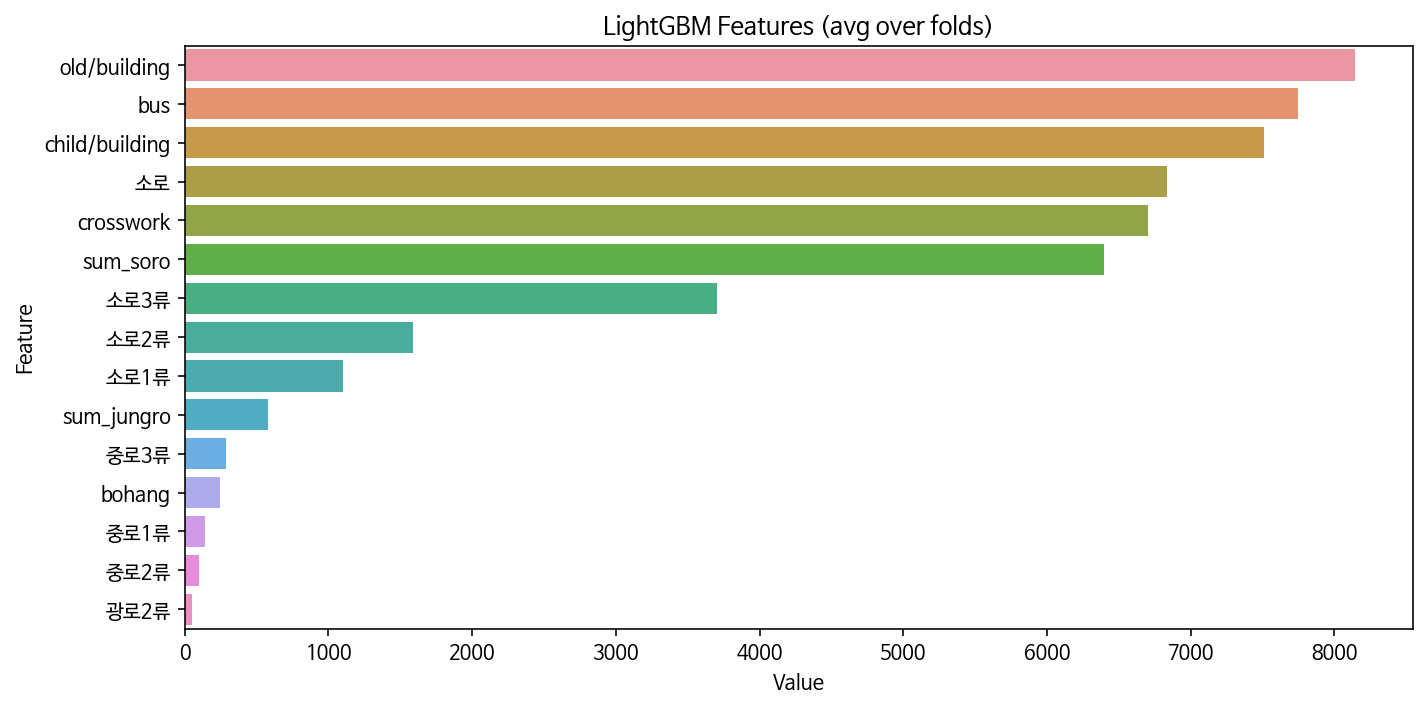

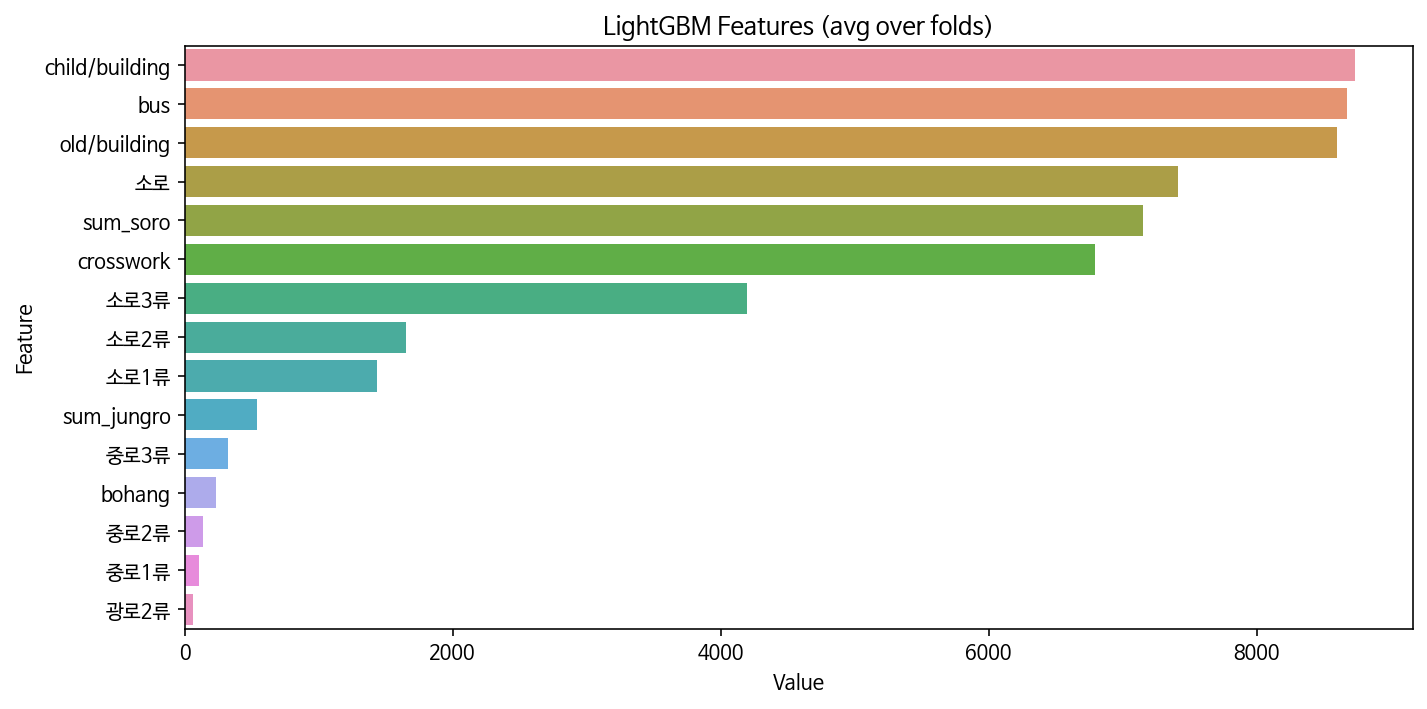

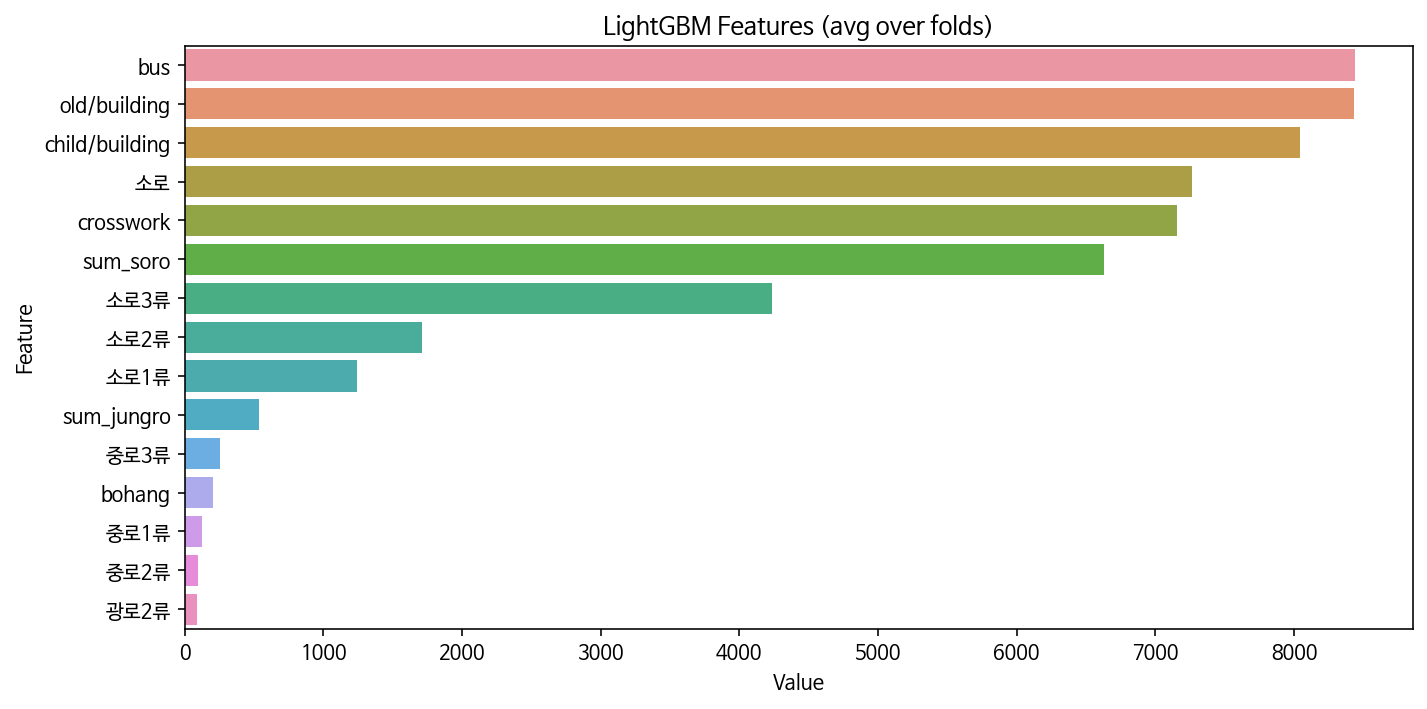

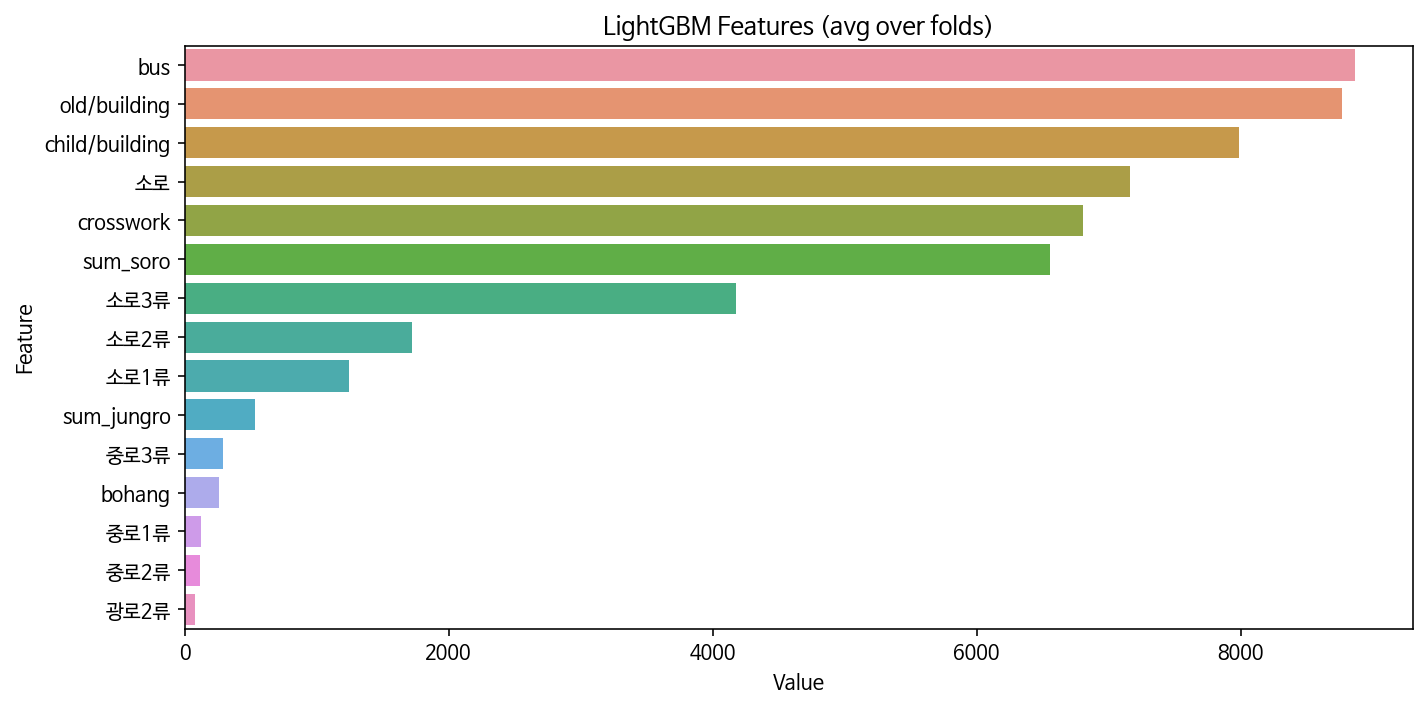

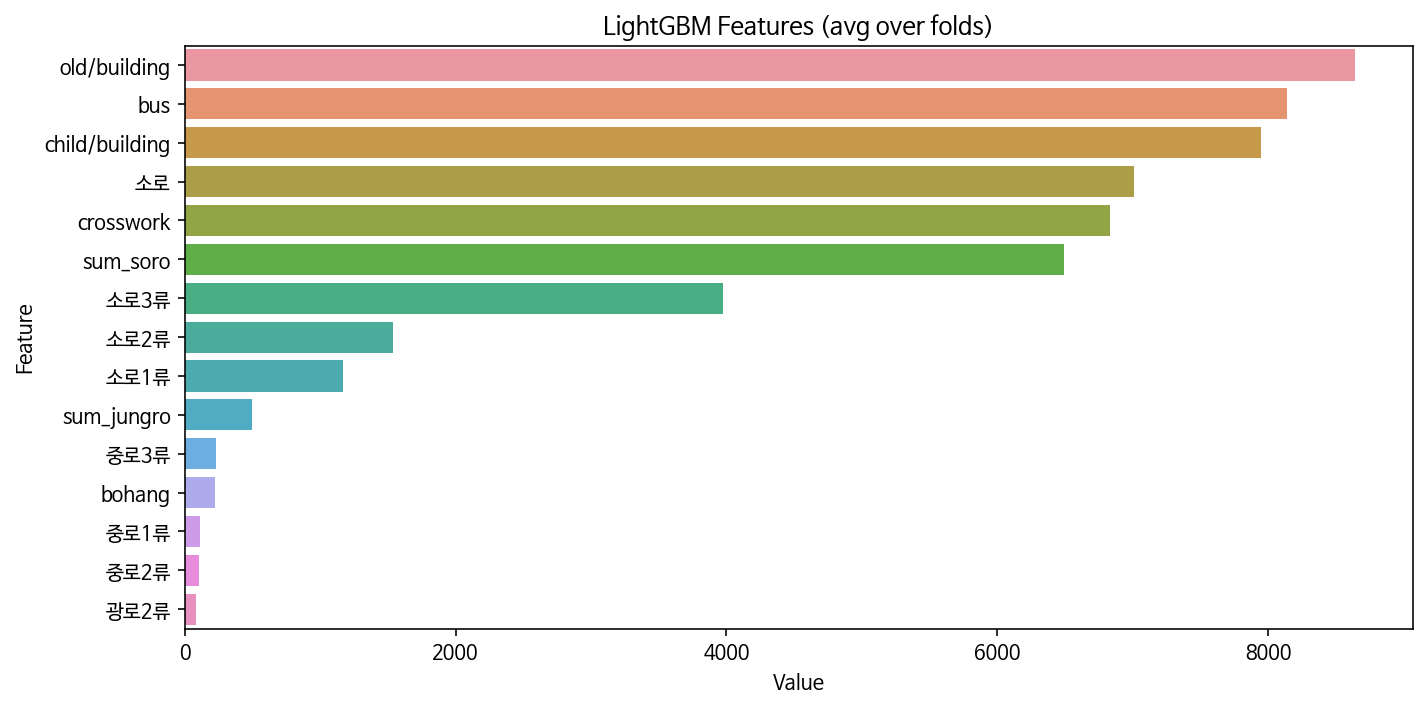

In [25]:
for model in models:
    feature_imp = pd.DataFrame(sorted(zip(model.feature_importances_,X_train.columns)), columns=['Value','Feature'])

    plt.figure(figsize=(10, 5))
    sns.barplot(x="Value", y="Feature", data=feature_imp.sort_values(by="Value", ascending=False))
    plt.title('LightGBM Features (avg over folds)')
    plt.tight_layout()
    plt.show()

## treemodel(다중분류)

In [0]:
data = pd.read_csv('/content/drive/My Drive/Colab Notebooks/data/공모전/동작구_공모전/sell_오만_250.csv')
data.drop('Unnamed: 0',axis=1,inplace=True)

In [0]:
# 파생변수 제작
data['old/building'] = data['old_place']/data['building']
data['child/building'] = data['child_place']/data['building']
data['sum_soro'] = data['소로'] +data['소로1류'] +data['소로2류']+data['소로3류']
data['sum_jungro'] = data['중로1류'] +data['중로2류']+data['중로3류']

In [0]:
# 다중분류
data['accident'].value_counts()
data.loc[data['accident']==0,'accident']=0
data.loc[(data['accident']>0)&(data['accident']<5),'accident']=1
data.loc[data['accident']>=5,'accident']=2

In [0]:
X_train=data.drop(['x','y','accident','building','old_place','child_place'],axis=1)
y_train=data['accident']

In [0]:
#X_train,X_test,y_train,y_test = train_test_split(X_train,y_train,test_size=0.3,random_state=4321,straify=y_train)

In [0]:
X_train.replace([np.inf, -np.inf], 0, inplace=True)
X_train.fillna(0,inplace=True)
# X_test.replace([np.inf, -np.inf], 0, inplace=True)
# X_test.fillna(0,inplace=True)

### oversampling

In [0]:
def lgb_cv(num_leaves, learning_rate, n_estimators, subsample, colsample_bytree, reg_alpha,reg_lambda, x_data=None, y_data=None, n_splits=5, output='model'):
    score = 0
    skf = StratifiedKFold(n_splits=n_splits, shuffle=True, random_state=201)
    models = []
    sm = SMOTE(ratio='auto', kind='regular')
    for train_index, valid_index in skf.split(x_data,y_data):
       #print(train_index)
       x_train, y_train = x_data.iloc[train_index], y_data.iloc[train_index]
       
       #Smote
       sm = SMOTE(ratio='auto', kind='regular')
       # train데이터를 넣어 복제함
       X_resampled, y_resampled = sm.fit_sample(x_train,y_train)
       x_valid, y_valid = x_data.iloc[valid_index], y_data.iloc[valid_index]
        
       model = lgb.LGBMClassifier(
               
           num_leaves = int(num_leaves), 
           learning_rate = learning_rate, 
           n_estimators = int(n_estimators), 
           subsample = np.clip(subsample, 0, 1), 
           colsample_bytree = np.clip(colsample_bytree, 0, 1), 
           reg_alpha = reg_alpha, 
           reg_lambda = reg_lambda,
           )
       
       model.fit(X_resampled, y_resampled)
       models.append(model)
        
       pred = model.predict(x_valid)
       true = y_valid
       score += f1_score(true, pred,average="weighted")/n_splits
    
    if output == 'score':
        return score
    if output == 'model':
        return models

In [33]:
func_fixed = partial(lgb_cv, x_data=X_train, y_data=y_train, n_splits=5, output='score') 

lgbBO = BayesianOptimization(
    func_fixed, 
    {
        'num_leaves': (16, 1024),
        'learning_rate': (0.0001, 0.1),
        'n_estimators': (16, 2048),#1024),
        'subsample': (0.1, 1),
        'colsample_bytree': (0, 1),
        'reg_alpha': (0.1, 10), 
        'reg_lambda': (0.1, 50),
    }, 
    random_state=4321
)
lgbBO.maximize(init_points=5, n_iter=5) #30

|   iter    |  target   | colsam... | learni... | n_esti... | num_le... | reg_alpha | reg_la... | subsample |
-------------------------------------------------------------------------------------------------------------
|  1        |  0.7582   |  0.0708   |  0.08152  |  1.576e+0 |  304.6    |  2.012    |  48.95    |  0.4656   |
|  2        |  0.9072   |  0.7578   |  0.009006 |  645.7    |  639.9    |  4.653    |  10.99    |  0.6972   |
|  3        |  0.9296   |  0.6787   |  0.09504  |  587.5    |  640.8    |  3.895    |  20.08    |  0.9484   |
|  4        |  0.9246   |  0.9299   |  0.09484  |  779.0    |  361.0    |  6.681    |  2.212    |  0.309    |
|  5        |  0.922    |  0.4301   |  0.007886 |  1.574e+0 |  876.7    |  1.589    |  5.147    |  0.3438   |
|  6        |  0.7534   |  0.9964   |  0.1      |  16.0     |  16.0     |  10.0     |  50.0     |  0.9971   |
|  7        |  0.9104   |  1.0      |  0.1      |  16.0     |  1.024e+0 |  0.1      |  0.1      |  0.4699   |
|  8      

In [0]:
params = lgbBO.max['params']
models = lgb_cv(
    params['num_leaves'],   
    params['learning_rate'], 
    params['n_estimators'], 
    params['subsample'], 
    params['colsample_bytree'], 
    params['reg_alpha'], 
    params['reg_lambda'], 
    x_data=X_train, y_data=y_train, n_splits=5, output='model')

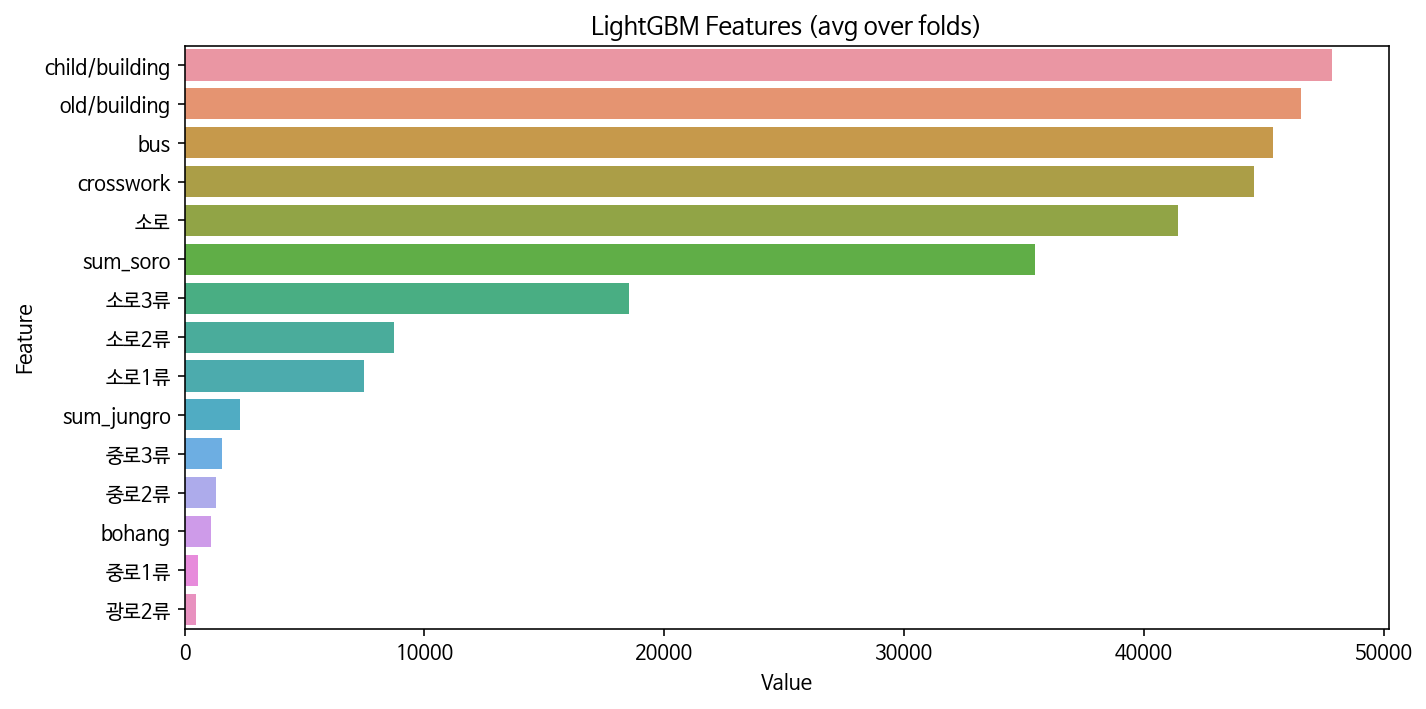

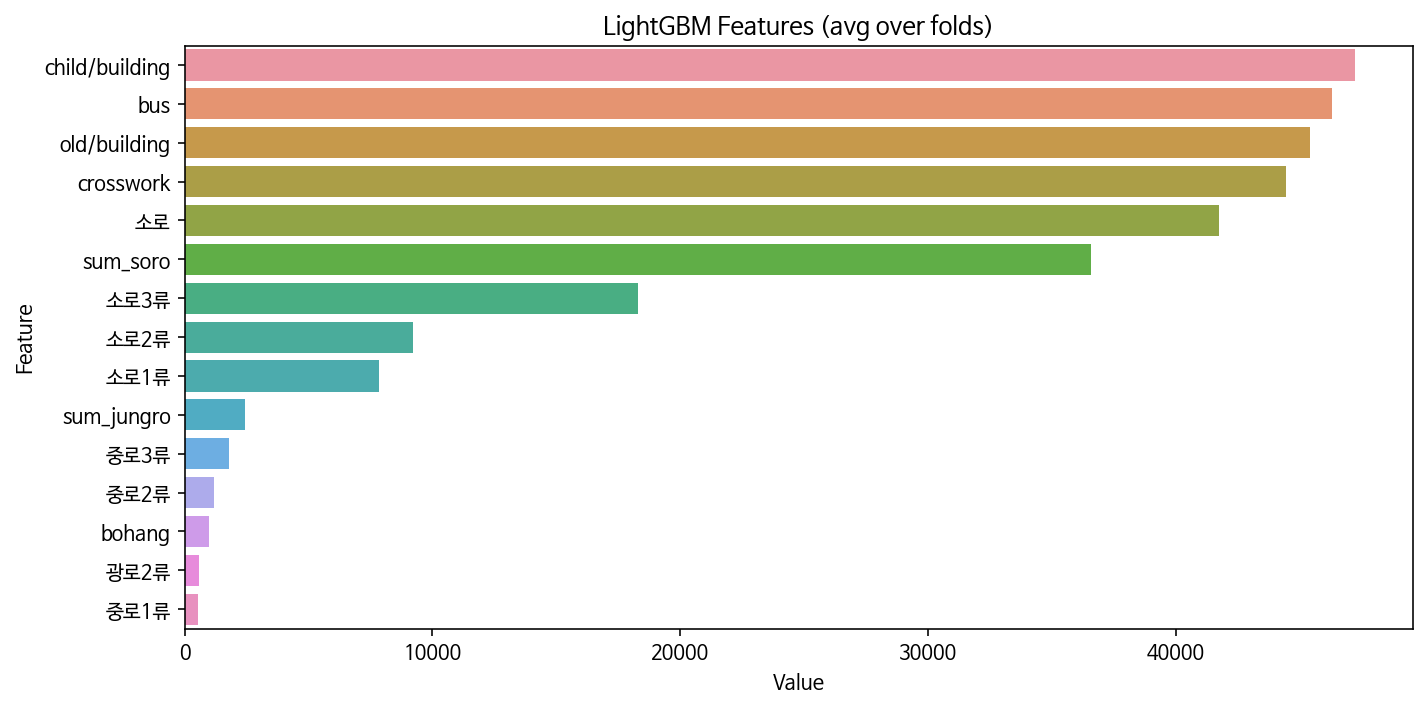

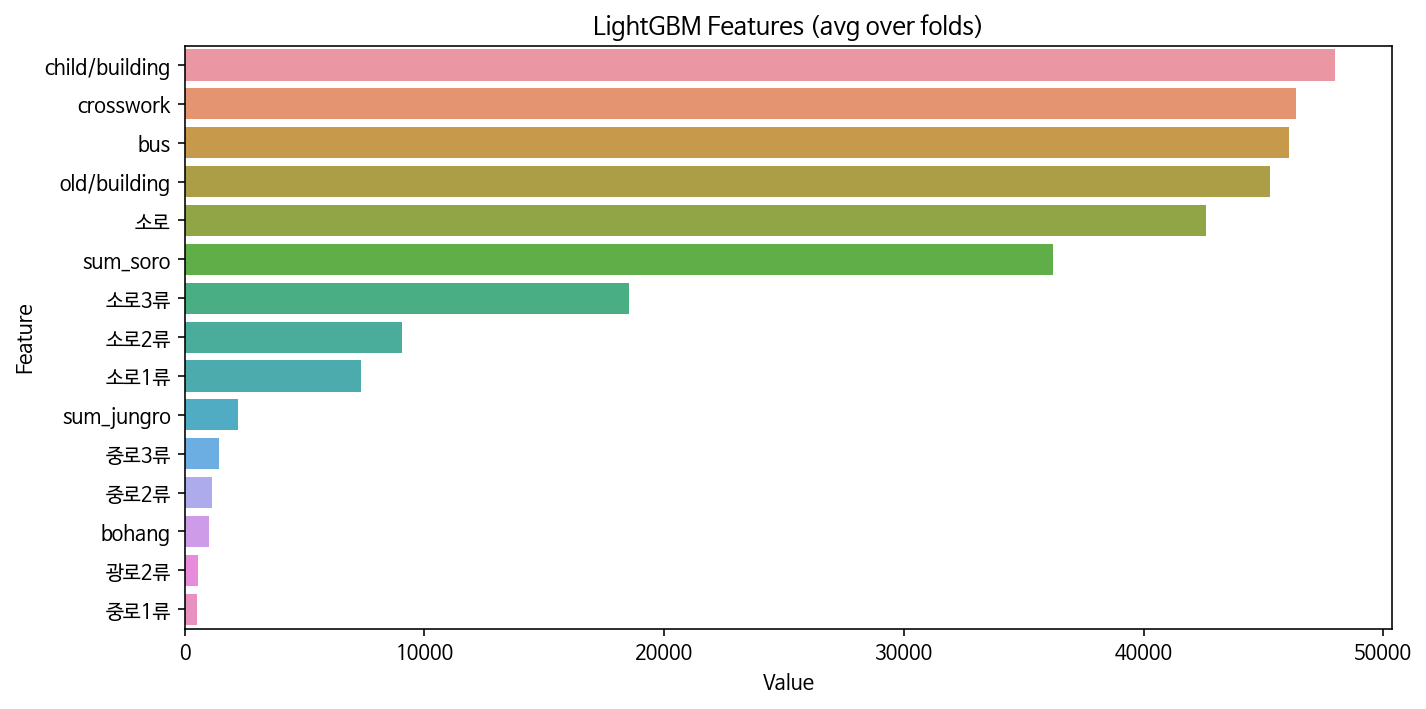

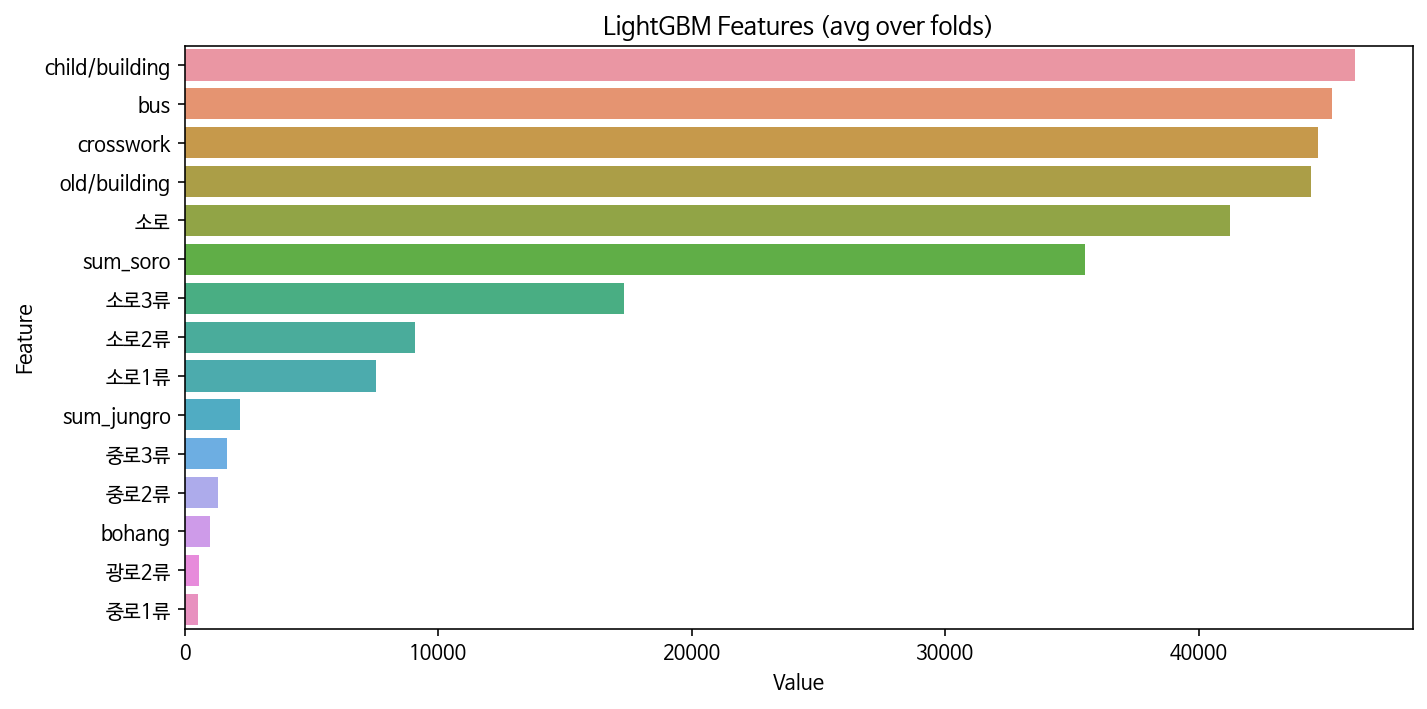

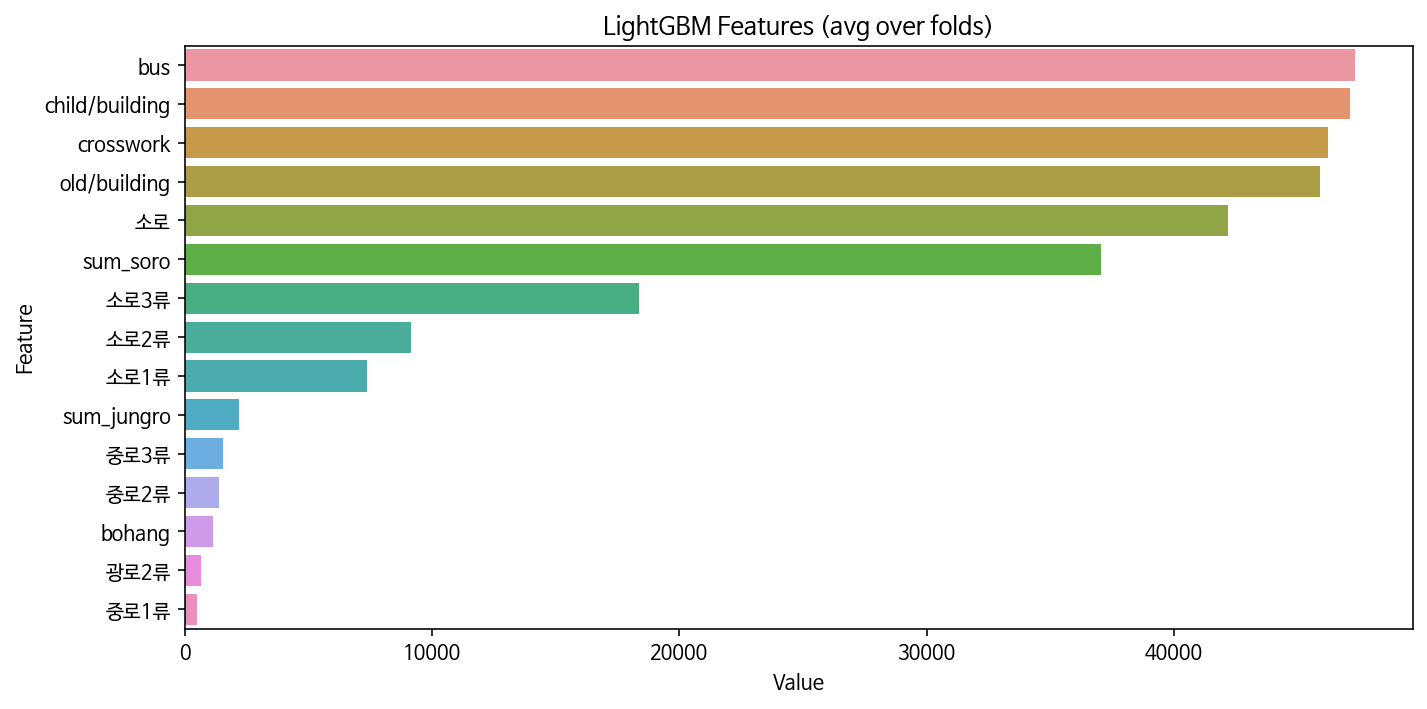

In [35]:
for model in models:
    feature_imp = pd.DataFrame(sorted(zip(model.feature_importances_,X_train.columns)), columns=['Value','Feature'])

    plt.figure(figsize=(10, 5))
    sns.barplot(x="Value", y="Feature", data=feature_imp.sort_values(by="Value", ascending=False))
    plt.title('LightGBM Features (avg over folds)')
    plt.tight_layout()
    plt.show()